<p align="center">
    <h1 align="center">DCGAN on fashion MNIST</h1>
    <img src="https://i.ibb.co/0Vy64NQ/dataset-cover.png" alt="dcgan">
</p>

<h1>Importing necessary libraries</h1>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import glob
import imageio
import os
import PIL
import time

In [2]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-4rh5n98f
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-4rh5n98f
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0faa3036804c619e180ffe69e2c0638efaf085ba5_-cp36-none-any.whl size=146699 sha256=0bd1a11a32521350a96e19668f2fbadee048b82c00fb259bce57761536cf8493
  Stored in directory: /tmp/pip-ephem-wheel-cache-32cuu_eg/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


<h1>Load and prepare the dataset</h1>

The tf.keras.datasets module provide a few toy datasets (already-vectorized, in Numpy format) that can be used for debugging a model
or creating simple code examples.
Here, we load fashion mnist datasets.

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the pixel values of images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<h1>Model Creation</h1>

><b>GANS consist of two neural networks:</b><br>
1. <b>Generator:</b> Generates images that looks real <br>
2. <b>Discriminator:</b> Classify the output of the generator as fake or real.

<br>
Here, we'll be using Deep Convolutional Generative Adversarial Network (DCGAN).

<h1>Define Generator</h1>

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until the desired image size of 28x28x1 is reached.

In [7]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256))) 
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))   

    return model

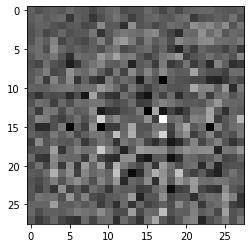

In [8]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

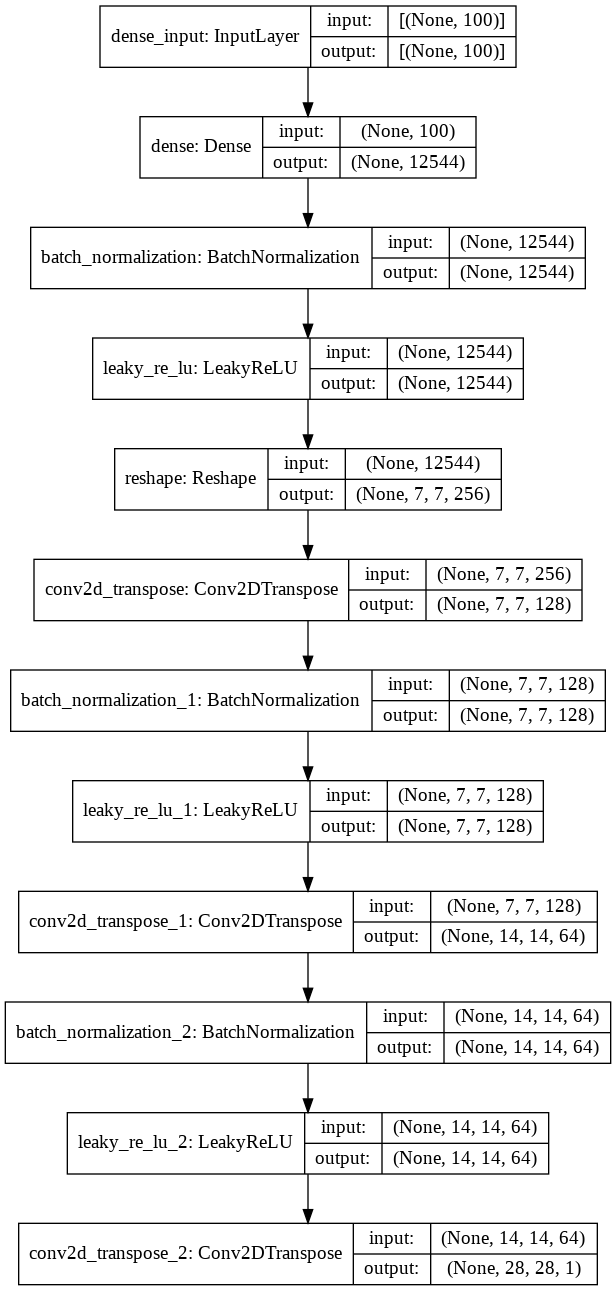

In [9]:
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

<h1>Define Discriminator</h1>

The discriminator is a CNN-based image classifier.

In [10]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00165555]], shape=(1, 1), dtype=float32)


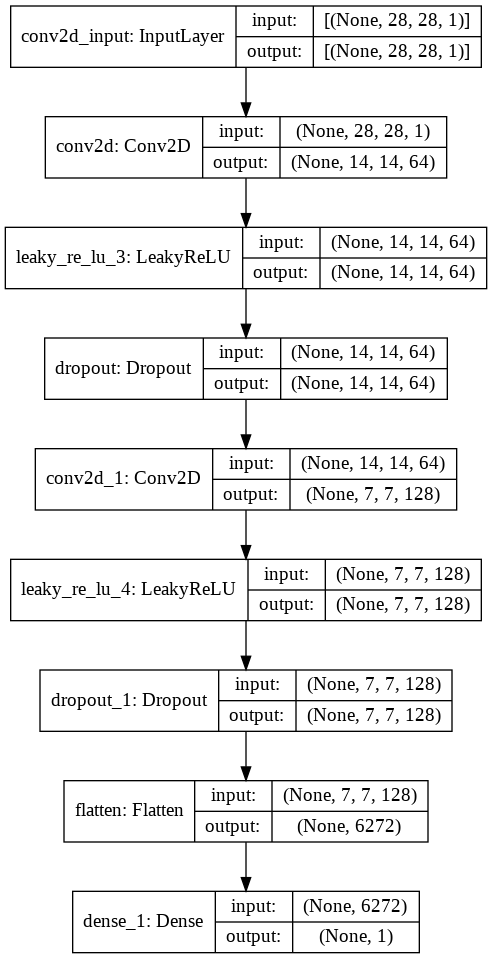

In [12]:
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

<h1> Defining loss and optimizers</h1>

Define loss functions and optimizers for both models.


In [13]:
# function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

<b> Discriminator loss</b><br>
While the discriminator is trained, it classifies both the real data and the fake data from the generator.<br>
It penalizes itself for misclassifying a real instance as fake, or a fake instance (created by the  generator) as real, by maximizing the below function.<br>
<p align="center">
<img src="https://i.ibb.co/k0xVPFc/discriminatorloss.jpg" alt="discriminatorloss">
</p>

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

<b> Generator loss</b><br>
While the generator is trained, it samples random noise and produces an output from that noise. The output then goes through the discriminator and gets classified as either “Real” or “Fake” based on the ability of the discriminator to tell one from the other.

The generator loss is then calculated from the discriminator’s classification – it gets rewarded if it successfully fools the discriminator, and gets penalized otherwise. 

The following equation is minimized to training the generator:
<p align="center">
<img src="https://i.ibb.co/m8fy3ZW/generator-Loss.jpg" alt="generator-Loss">
</p>

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

<b>Save checkpoints</b><br>
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<h1>Define the training loop</h1>


In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [19]:
# tf.function is used to complile the defined function.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

<h1>Train the model</h1>

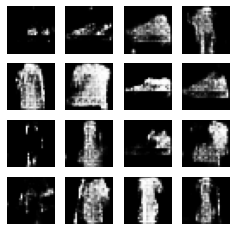

In [22]:
train(train_dataset, EPOCHS)

<b>Restore the latest checkpoint:</b>

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<h1>Create a GIF</h1>


In [24]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

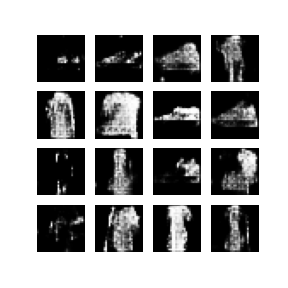

In [25]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [26]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


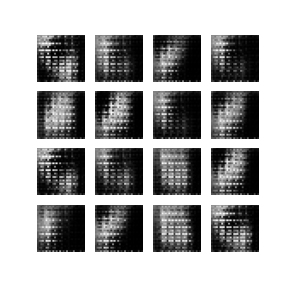

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

<h1>Generated Images</h1>

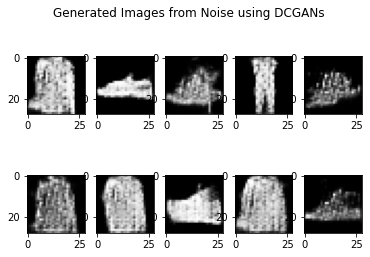

In [28]:
noise=np.random.normal(loc=0, scale=1, size=(100,noise_dim))
gen_image = generator.predict(noise)

fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using DCGANs')
idx=0
for i in range(2):
     for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=3

<h1>Check Actual Images</h1>

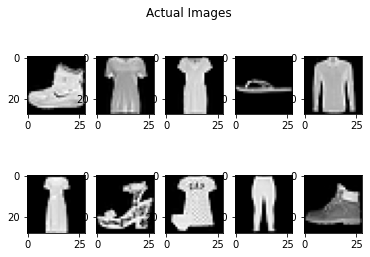

In [29]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(train_images[idx].reshape(28,28),cmap='gray')
        idx+=10